In [1]:
# 屏蔽Jupyter的warning訊息
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
from scipy import misc
import sys
import os
import random
from tqdm import tqdm

# 多維向量處理相關函式庫
import numpy as np

# 圖像處理相關函式庫
import cv2

# 深度學習相關函式庫
import tensorflow as tf

# 專案相關函式庫
import facenet
import detect_face

# 隨機變數函式庫
import random

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 模型的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# MTCNN的模型
MTCNN_MODEL_PATH = os.path.join(MODEL_PATH, "mtcnn")

# 訓練/驗證用的圖像資料目錄
IMG_IN_PATH = os.path.join(DATA_PATH, "lfw")

# 訓練/驗證用的圖像資料目錄
IMG_OUT_PATH = os.path.join(DATA_PATH, "lfw_crops")

In [3]:
# 檢查要儲放裁剪結果的目錄
if not os.path.exists(IMG_OUT_PATH):
        os.makedirs(IMG_OUT_PATH)


# 臉類別(ImageClass)的列表與圖像路徑
dataset = facenet.get_dataset(IMG_IN_PATH)

In [4]:
# 打印看有多少人臉的身份
print("Total face identities: ", len(dataset))

Total face identities:  6


In [5]:
print('Creating networks and loading parameters')
with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, MTCNN_MODEL_PATH)

Creating networks and loading parameters
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
minsize = 20  # 最小的臉部的大小
threshold = [0.6, 0.7, 0.7]  # 三個網絡(P-Net, R-Net, O-Net)的閥值
factor = 0.709  # scale factor

margin = 44 # 在裁剪人臉時的邊框margin
image_size = 182 # 160 + 22

In [7]:
# 將一個隨機key添加到圖像檔名以允許使用多個進程進行人臉對齊
random_key = np.random.randint(0, high=99999)
bounding_boxes_filename = os.path.join(IMG_OUT_PATH, 'bounding_boxes_%05d.txt' % random_key)

In [8]:
#使用Tensorflow來運行MTCNN
with open(bounding_boxes_filename, "w") as text_file:
    nrof_images_total = 0 # 處理過的圖像總數
    nrof_successfully_aligned = 0 # 人臉圖像align的總數
    
    # 迭代每一個人臉身份(ImageClass)
    for cls in tqdm(dataset):
        output_class_dir = os.path.join(IMG_OUT_PATH, cls.name) # 裁剪後的圖像目錄
        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)
        
        # 迭代每一個人臉身份的圖像的路徑 (ImageClass.image_paths)
        for image_path in cls.image_paths:
            nrof_images_total += 1
            filename = os.path.splitext(os.path.split(image_path)[1])[0] # 取得圖像檔名
            output_filename = os.path.join(output_class_dir, filename + '.png') # 設定輸出的圖像檔名            
            #print(image_path)
            
            if not os.path.exists(output_filename):
                try:
                    img = misc.imread(image_path) # 讀進圖檔
                    # print('read data dimension: ', img.ndim)                    
                except (IOError, ValueError, IndexError) as e:
                    errorMessage = '{}: {}'.format(image_path, e)
                    # print(errorMessage)
                else:
                    # 將圖檔轉換成numpy array (height, widith, color_channels)
                    if img.ndim < 2:
                        print('Unable to align "%s"' % image_path)
                        text_file.write('%s\n' % (output_filename))
                        continue
                    if img.ndim == 2:
                        img = facenet.to_rgb(img)
                        print('to_rgb data dimension: ', img.ndim)
                    img = img[:, :, 0:3]
                    # print('after data dimension: ', img.ndim)
                    
                    # 使用MTCNN來偵測人臉在圖像中的位置
                    bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
                    nrof_faces = bounding_boxes.shape[0] # 偵測到的人臉總數
                     #print('detected_face: %d' % nrof_faces)
                    if nrof_faces > 0:
                        # 當有偵測到多個人臉的時候, 我們希望從中找到主要置中位置的人臉
                        det = bounding_boxes[:, 0:4]
                        img_size = np.asarray(img.shape)[0:2]
                        if nrof_faces > 1:
                            bounding_box_size = (det[:, 2] - det[:, 0]) * (det[:, 3] - det[:, 1])
                            img_center = img_size / 2
                            offsets = np.vstack([(det[:, 0] + det[:, 2]) / 2 - img_center[1],
                                                 (det[:, 1] + det[:, 3]) / 2 - img_center[0]])
                            offset_dist_squared = np.sum(np.power(offsets, 2.0), 0)
                            index = np.argmax(bounding_box_size - offset_dist_squared * 2.0)  # some extra weight on the centering
                            det = det[index, :]
                        det = np.squeeze(det)
                        bb_temp = np.zeros(4, dtype=np.int32)
                        # 取得人臉的左上角與右下角座標
                        bb_temp[0] = det[0]
                        bb_temp[1] = det[1]
                        bb_temp[2] = det[2]
                        bb_temp[3] = det[3]
                        
                        # 進行裁剪以及大小的轉換
                        cropped_temp = img[bb_temp[1]:bb_temp[3], bb_temp[0]:bb_temp[2], :]
                        scaled_temp = misc.imresize(cropped_temp, (image_size, image_size), interp='bilinear')

                        nrof_successfully_aligned += 1
                        misc.imsave(output_filename, scaled_temp) # 儲存處理過的圖像
                        text_file.write('%s %d %d %d %d\n' % (output_filename, bb_temp[0], bb_temp[1], bb_temp[2], bb_temp[3]))
                    else:
                        # print('Unable to align "%s"' % image_path)
                        text_file.write('%s\n' % (output_filename))

print('Total number of images: %d' % nrof_images_total)
print('Number of successfully aligned images: %d' % nrof_successfully_aligned)

100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

Total number of images: 67
Number of successfully aligned images: 1


In [9]:
import matplotlib.pyplot as plt

face_identity = 'group'
origin_face_image = os.path.join(IMG_IN_PATH, face_identity, 'yuan01.bmp')
aligned_face_image = os.path.join(IMG_OUT_PATH, face_identity, 'yuan01.bmp')

zface_identity = 'yuanhan'
zorigin_face_image = os.path.join(IMG_IN_PATH, zface_identity, 'yuanhan_002.jpg')
zaligned_face_image = os.path.join(IMG_OUT_PATH, zface_identity, 'yuanhan_002.png')

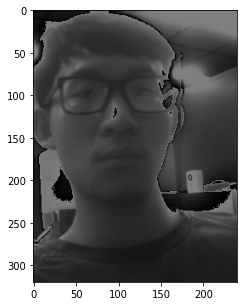

Total faces_detected ：1


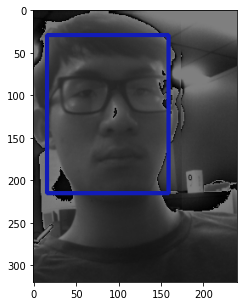

'plt.imshow(zdraw[:,:,::-1]) # 轉換成RGB來給matplotlib展示\nplt.show()'

In [10]:
# 使用OpenCV讀入測試圖像
# 注意: OpenCV讀進來的圖像所產生的Numpy Ndaary格式是BGR (B:Blue, G: Green, R: Red) 
#      跟使用PIL或skimage的格式RGB (R: Red, G: Green, B:Blue)在色階(channel)的順序上有所不同
bgr_image = cv2.imread(origin_face_image)
rgb_image = bgr_image[:,:,::-1] # 把BGR轉換成RGB
plt.figure(figsize=(10,5))
plt.imshow(rgb_image)
plt.show()

#zbgr_image = cv2.imread(zorigin_face_image)
#zrgb_image = zbgr_image[:,:,::-1] # 把BGR轉換成RGB
# 偵測人臉
bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)

#zbounding_boxes, _ = detect_face.detect_face(zrgb_image, minsize, pnet, rnet, onet, threshold, factor)
# 複製原圖像
draw = bgr_image.copy()

#zdraw = zbgr_image.copy()
# 被偵測到的臉部總數
faces_detected = len(bounding_boxes)

#zfaces_detected = len(zbounding_boxes)
print('Total faces_detected ：{}'.format(faces_detected))

#print('Total zfaces_detected ：{}'.format(zfaces_detected))
# 每一個 bounding_box包括了（x1,y1,x2,y2,confidence score)：
# 　　左上角座標 (x1,y1)
#     右下角座標 (x2,y2)
#     信心分數 confidence score

# 迭代每一個偵測出來的邊界框
for face_position in bounding_boxes:
    # 把資料由float轉成int
    face_position=face_position.astype(int)
    
    # 取出左上角座標 (x1,y1)與右下角座標 (x2,y2)
    # 由於有可能預測出來的臉在圖像的圖邊而導致座標值為負值
    # 因此進行的負值的偵測與修正
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # 在原圖像上畫上這些邊界框
    R = random.randint(0,255)
    G = random.randint(0,255)
    B = random.randint(0,255)
    cv2.rectangle(draw, (x1, y1), (x2, y2), (R, G, B), 3)
plt.figure(figsize=(10,5))
'''for face_position in zbounding_boxes:
    # 把資料由float轉成int
    face_position=face_position.astype(int)
    
    # 取出左上角座標 (x1,y1)與右下角座標 (x2,y2)
    # 由於有可能預測出來的臉在圖像的圖邊而導致座標值為負值
    # 因此進行的負值的偵測與修正
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # 在原圖像上畫上這些邊界框
    R = random.randint(0,255)
    G = random.randint(0,255)
    B = random.randint(0,255)
    cv2.rectangle(zdraw, (x1, y1), (x2, y2), (R, G, B), 3)
# 設定展示的大小
plt.figure(figsize=(10,5))'''

# 展示偵測出來的結果
plt.imshow(draw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()
'''plt.imshow(zdraw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()'''

In [11]:
#gr_image = cv2.imread(aligned_face_image)
#rgb_image = bgr_image[:,:,::-1] # 把BGR轉換成RGB

# 設定展示的大小
#plt.figure(figsize=(8,3))

# 展示偵測出來的結果
#plt.imshow(rgb_image) # 轉換成RGB來給matplotlib展示
#plt.show()

In [12]:
for root, dirs, files  in os.walk("./data/lfw", topdown = False):
    '''for name in files:
        print(os.path.join(root,name))'''
    for name in dirs :
        print(name)
        read_directory(name)




tomyuan


NameError: name 'read_directory' is not defined

In [ ]:

for root, dirs, files  in os.walk("./data/lfw", topdown = False):
    for name in files:
        print(os.path.join(root,name))
    for name in dirs :
        print(os.path.join(root,name))